<a href="https://colab.research.google.com/github/quantumalaviya/FormOCR/blob/main/FormOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I suggest reading the accompanying documents and the writeup to understand my approach. This approach has great generalization and accurate results. Please check that these files are available in the submitted code:<br>
1) page1.PNG ----> The empty form to be used as template.<br>
2) pg1.PNG ----> The filled form to be parsed to string. <br>
3) writeup.pdf ----> The rundown of the approach. <br>
4) result.pdf ----> The final result.<br>
5) extra.pdf ----> The assumptions and suggested improvements. This is to show how this approach can definitely be used in a real-life scenario with great generalization and perfect accuracy.<br>
6) alphaModel.h5 ----> The weights for the alphabet recognition model (alphaModel).<br>
7) digiModel.h5 ----> The weights for the digit recognition model (digiModel).<br>

Loading all the required packages for the template forming and form localization part

In [ ]:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow

First we will load the original form, as two pages. Here, only one part of the first page is being taken. Read "result.pdf" for more information. The file to be uploaded is "page1.PNG". This is also available in the root folder submitted. Upload it when prompted.

In [ ]:
files.upload()
page1 = cv2.imread("page1.PNG")
#page2 = cv2.imread("page2.PNG")

Saving page1.PNG to page1.PNG


Optional visualization. This is the kind of resolution we need to be working with. That's why I've chosen to work with just one part of the form. That being said, an OMR scanner may be used on the whole form for similar results and the same approach may be used. This is explained in detail in "result.pdf" and "extra.pdf".

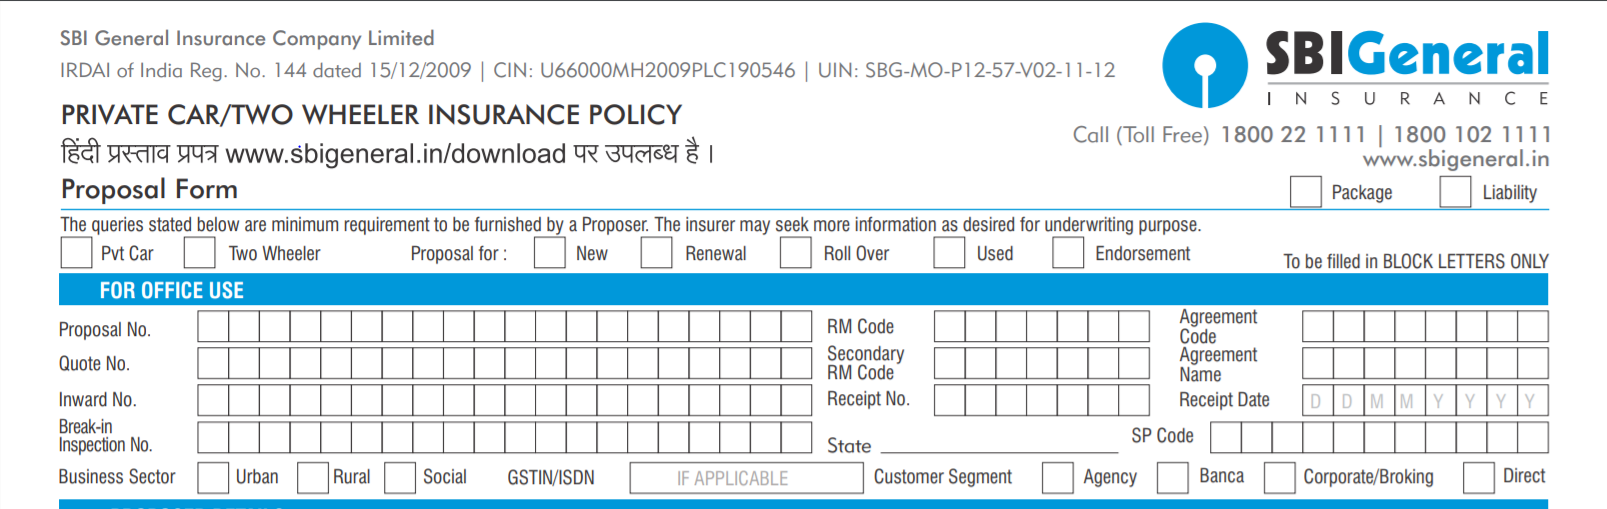

In [ ]:
cv2_imshow(page1)
#cv2_imshow(page2)

Preprocessing template:<br>
1) Removing blue shades.<br>
2) Defining kernels to detect vertical and horizontal lines.<br>
3) Using the kernels to process these lines and merge them together to get boxes<br>
4) Defining contours and sorting them

In [ ]:
def pageContour(img):
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  #remove blue
  lower_blue = np.array([85, 50, 40])
  upper_blue = np.array([135, 255, 255])

  mask = cv2.inRange(hsv, lower_blue, upper_blue)

  img[mask>0]=(255, 255, 255)
  img = img[:,:,2]

  _, img = cv2.threshold(img, 105, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

  img = 255-img
  
  #defining kernels
  kernel_length = np.array(img).shape[1]//150
  vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
  horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

  #mask with vertical lines
  temp = cv2.erode(img, vertical, iterations=3)
  verticalImg = cv2.dilate(temp, vertical, iterations=3)[5:]
  verticalImg = cv2.resize(verticalImg, (img.shape[1], img.shape[0]))

  #mask with horizontal lines
  temp = cv2.erode(img, horizontal, iterations=3)
  horizontalImg = cv2.dilate(temp, horizontal, iterations=3)[:, 5:]
  horizontalImg = cv2.resize(horizontalImg, (img.shape[1], img.shape[0]))

  #merge
  imgFinal = cv2.addWeighted(verticalImg, 0.5, horizontalImg, 0.5, 0.0)
  imgFinal = cv2.erode(~imgFinal, kernel, iterations=1)
  _, imgFinal = cv2.threshold(imgFinal, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

  #return contours and finally sorting
  contours, _ = cv2.findContours(imgFinal, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  boundingBoxes = [cv2.boundingRect(c) for c in contours]
  #sorting
  contours, boundingBoxes = zip(*sorted(zip(contours, boundingBoxes), key=lambda b:b[1][1]))

  return imgFinal, contours

Basically running the function defined above on a copy of the template. The contours derived will be stored in the variables page1Contours.

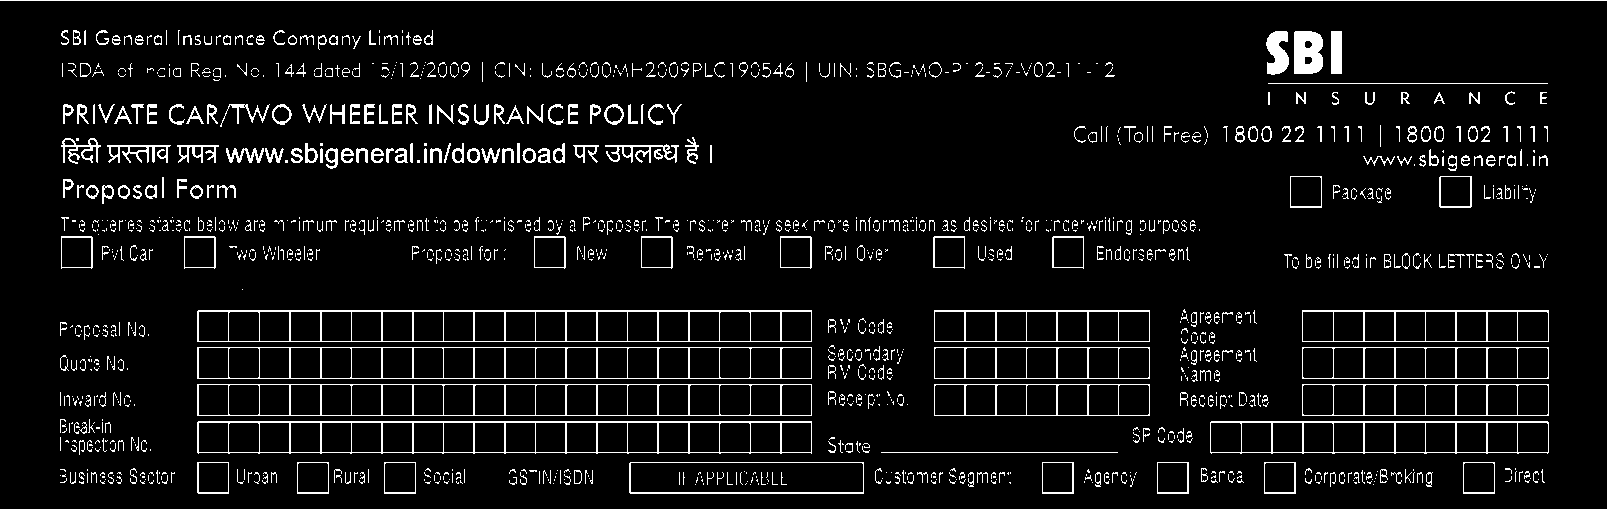

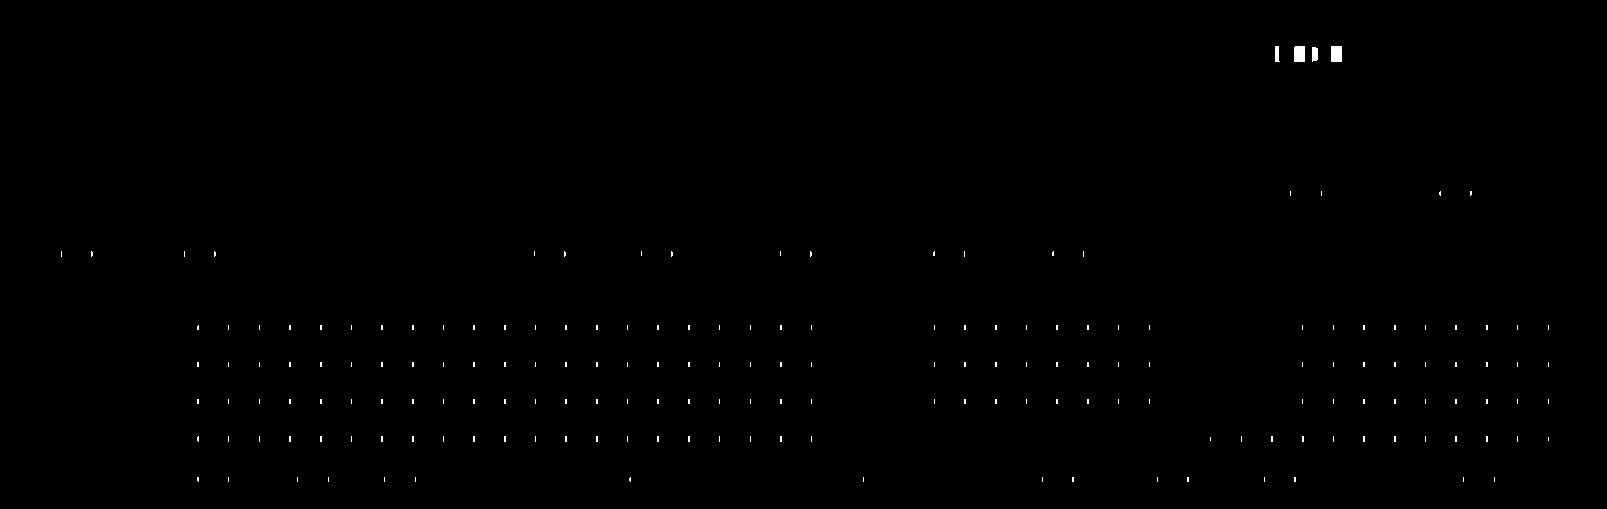

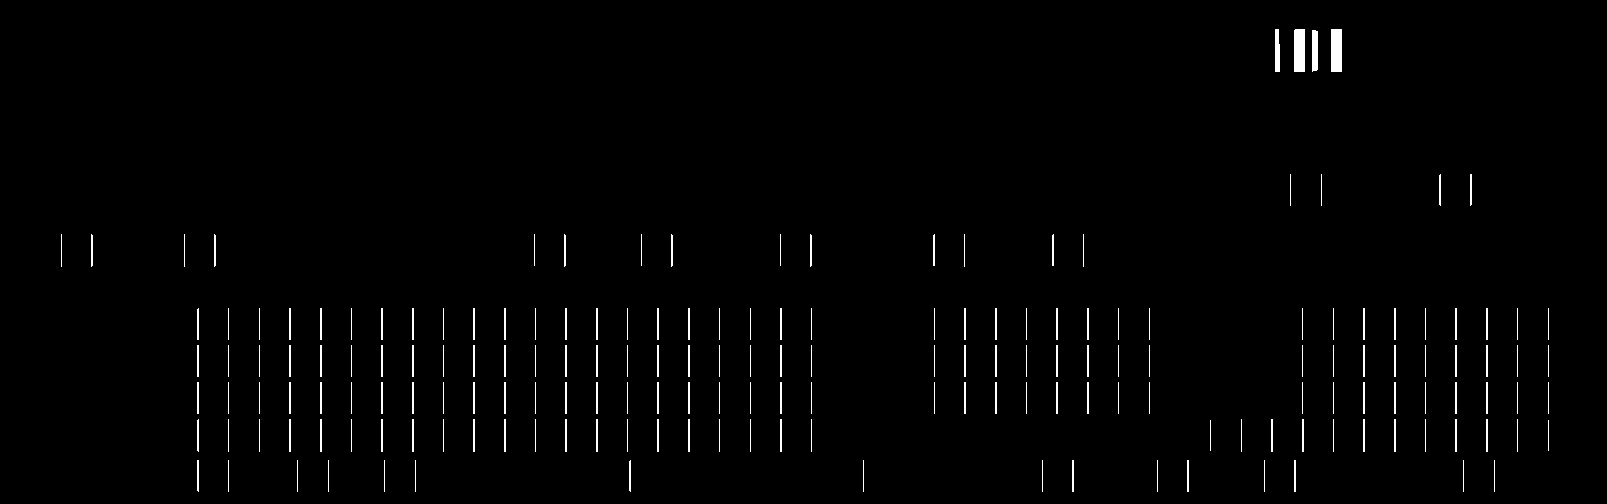

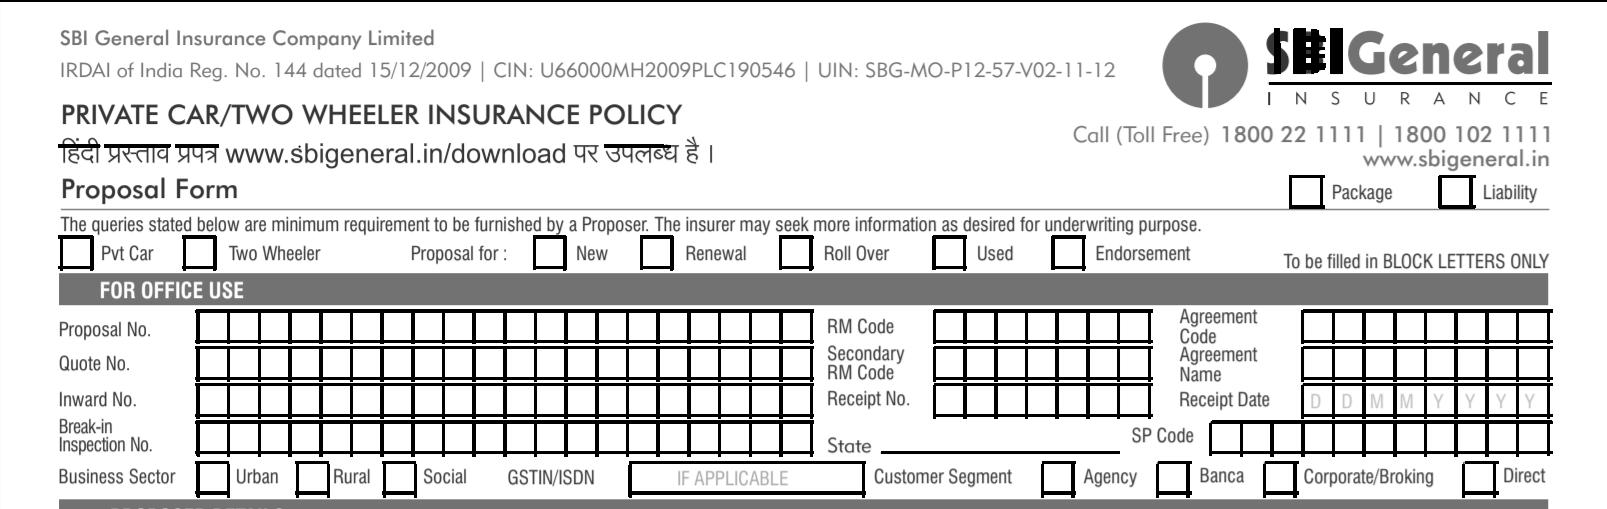

In [ ]:
page1Final, page1Contours = pageContour(page1.copy())
#page2Final, page2Contours = pageContour(page2)
dest = cv2.bitwise_and(cv2.cvtColor(page1, cv2.COLOR_BGR2GRAY), page1Final)
cv2_imshow(dest)
#dest = cv2.bitwise_and(cv2.cvtColor(page2, cv2.COLOR_BGR2GRAY), page2Final)
#cv2_imshow(dest)

Now that our "template" is created, we will have to process the filled form. First, an upload is in order. These is the file named "pg1.PNG". Upload on prompt.

Saving pg1.PNG to pg1.PNG


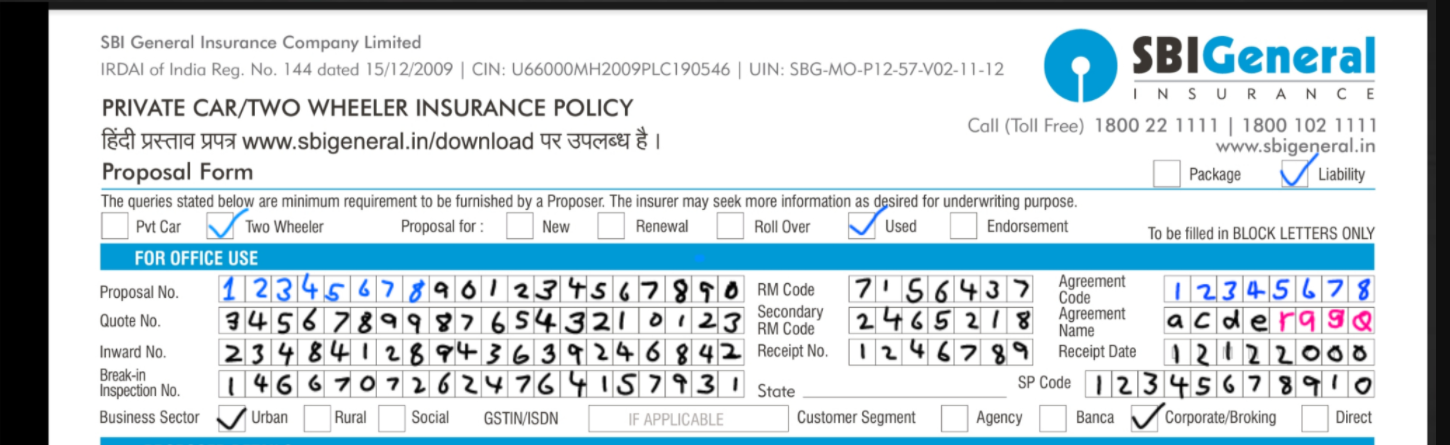

In [ ]:
files.upload()
pg1 = cv2.imread("pg1.PNG")
#page2 = cv2.imread("pg2.JPG")
cv2_imshow(pg1)
#cv2_imshow(pg2)

1) We will first detect edges. The steps are:<br>
-> Resize the image to the template dimensions.<br>
-> Use a gaussian blur for noise reduction. <br>
-> Use Canny edge detection.<br>
2) Now we find the contours of the page<br>
-> We start with normally finding contours. However, factors such as lighting and noise were making it difficult to capture all edges<br>
-> Use Convex Hull to complete and find contours (and sort it)<br>
->Find the 4 vertices of the quadrilateral that contains the form <br>
3)Apply perspective transform from these 4 vertices to the template's dimensions.


In [ ]:
def transformPG(pg, template):
  OG = cv2.imread(pg)
  pg = cv2.imread(pg)
  OG = cv2.resize(OG, (template.shape[1], template.shape[0]), interpolation = cv2.INTER_CUBIC)
  pg = cv2.resize(pg, (template.shape[1], template.shape[0]), interpolation = cv2.INTER_CUBIC)
 
  pg = cv2.GaussianBlur(pg, (5, 5), 0)
  edges = cv2.Canny(pg, 200, 250)
 
  contours, hierarchy = cv2.findContours(edges,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
 
  hull = []
  
  for i in range(len(contours)):
      hull.append(cv2.convexHull(contours[i], False))
  hull = sorted(hull, key = cv2.contourArea, reverse = True)[:5]
  for c in hull:
    p = cv2.arcLength(c, False)
    a = cv2.approxPolyDP(c, 0.02 * p, True)
    if len(a) == 4:
      points = a
      break
  pts = np.array([points[0][0], points[1][0], points[2][0], points[3][0]])
 
  s = pts.sum(axis = 1)
  diff = np.diff(pts, axis = 1)
  pts = np.float32([pts[np.argmin(s)], pts[np.argmin(diff)], pts[np.argmax(s)], pts[np.argmax(diff)]])
 
  dst = np.float32([[0, 0],
                    [template.shape[1], 0],
                    [template.shape[1], template.shape[0]],
                    [0, template.shape[0]]])
  M = cv2.getPerspectiveTransform(pts, dst)
  result = cv2.warpPerspective(OG, M, (template.shape[1], template.shape[0]))
  
  return result

Storing the image after perspective transform in the variable result. Notice how perfectly the function has defined our area of interest.

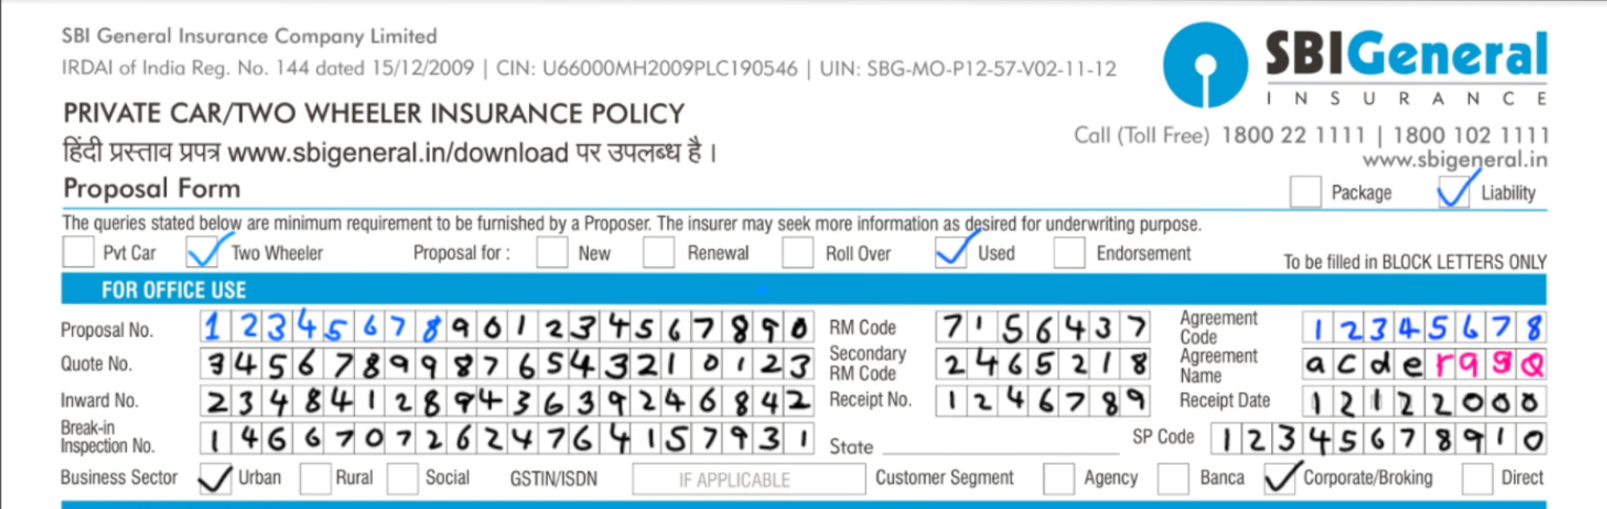

In [ ]:
result = transformPG("pg1.PNG", page1)
cv2_imshow(result)

Optional visualization to check how our template fits the result.

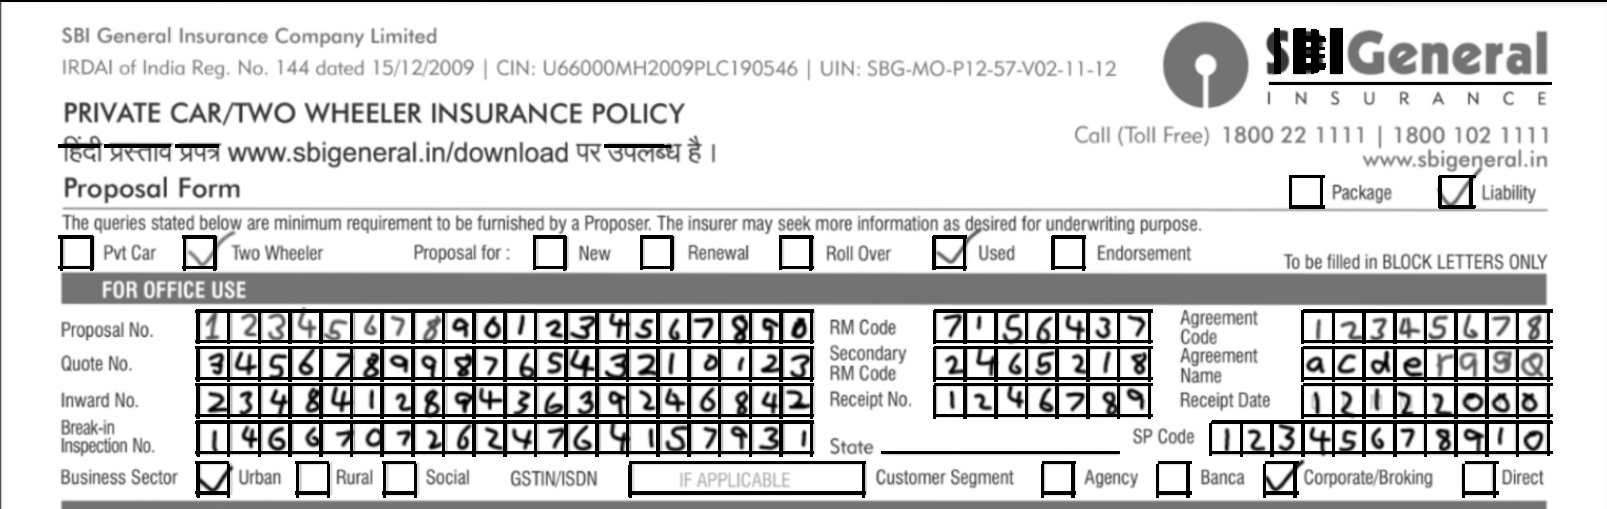

In [ ]:
dest = cv2.bitwise_and(cv2.cvtColor(result, cv2.COLOR_BGR2GRAY), page1Final)
cv2_imshow(dest)

That concludes our template forming and form preprocessing stage. Notice how the template is a great match for the filled form. Now we move on to defining and training (in this case loading weights) for two different models, one to recognize digits and one for alphabets

Libraries for Deep Learning.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
import os
import struct
import gzip
import matplotlib.pyplot as plt

Downloading the EMNIST dataset and unzipping the files. This will be used for the alphabet dataset.

In [ ]:
!wget http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
!unzip gzip

--2021-01-04 11:35:40--  http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
Resolving www.itl.nist.gov (www.itl.nist.gov)... 129.6.13.51, 2610:20:6b01:4::36
Connecting to www.itl.nist.gov (www.itl.nist.gov)|129.6.13.51|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip [following]
--2021-01-04 11:35:40--  https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
Connecting to www.itl.nist.gov (www.itl.nist.gov)|129.6.13.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561753746 (536M) [application/zip]
Saving to: ‘gzip.zip’

gzip.zip            100%[===================>] 535.73M  97.6MB/s    in 5.7s    

2021-01-04 11:35:46 (94.6 MB/s) - ‘gzip.zip’ saved [561753746/561753746]

Archive:  gzip.zip
  inflating: gzip/emnist-balanced-mapping.txt  
  inflating: gzip/emnist-balanced-test-images-idx3-ubyte.gz  
 extracting: gzip/emnist-balanced-test-labels-idx1-

Setting some constants needed for training and processing

In [ ]:
image_dir = 'gzip'
digiLabels = '0123456789'
alphaLabels = ".abcdefghijklmnopqrstuvwxyz"

Function to read the gzip files. Used some external help because this was my first time working with gzip files.

In [ ]:
def read(filename):
    with gzip.open(filename, 'rb') as f:
        z, dtype, dim = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dim))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

(EXPERIMENTAL) Adding noise to training data. This is the part I wanted to implement but didn't have the resources for (see "extra.pdf" for more information)

In [ ]:
def addNoise(X):
  n1 = X.copy()
  n1[:, 0:2, :] = 255
  n2 = X.copy()
  n2[:, :, 0:2] = 255
  n3 = X.copy()
  n3[:, 26:28, :] = 255
  n4 = X.copy()
  n4[:, :, 26:28] = 255

  nX = np.concatenate((X, n1, n2, n3, n4, (n1+n2), (n2+n3), (n3+n4), (n4+n1)))
  ny =  np.concatenate((y, y, y, y, y, y, y, y, y))
  
  return np.array(nX), np.array(ny)

Defining data generators. This will help with data augmentation without taking up extra RAM. It's one of my favorite keras functions.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')

Defining the model to be used. Inspired by https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

In [ ]:
def defModel(classes):
  model = Sequential()

  model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28, 1)))
  model.add(BatchNormalization())
  model.add(Conv2D(32,kernel_size=3,activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(64,kernel_size=3,activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,kernel_size=3,activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(classes, activation='softmax'))
  return model

This is the code that would train a model named digiModel on the MNIST. However, since I've already done that, I have commented the code out and the model will instead request for the saved weights "digiModel.h5". This has been attached in the submission file. Upload on prompt

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
train_datagen.fit(x_train)
test_datagen.fit(x_test)
digiModel = defModel(10) 
digiModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
files.upload()
digiModel.load_weights("digiModel.h5")

#digiModel.fit(train_datagen.flow(x_train, y_train, batch_size=100), epochs=10, validation_data = test_datagen.flow(x_test, y_test, batch_size=100))

11493376/11490434 [==============================] - 0s 0us/step


Saving digiModel.h5 to digiModel.h5


This is how weights would be saved, had this model been newly trained.

In [ ]:
#digiModel.save_weights("digiModel.h5")
#files.download("digiModel.h5")

Again, this is where I took some external help. This is a function that uses the gzip files processed and trains alphaModel on the EMNIST letters dataset. I would really prefer noise on these examples (see "extra.pdf").

In [ ]:
def load_emnist():
    train_images = os.path.join(image_dir, 'emnist-letters-train-images-idx3-ubyte.gz')
    train_labels = os.path.join(image_dir, 'emnist-letters-train-labels-idx1-ubyte.gz')
    test_images = os.path.join(image_dir, 'emnist-letters-test-images-idx3-ubyte.gz')
    test_labels = os.path.join(image_dir, 'emnist-letters-test-labels-idx1-ubyte.gz')

    train_X = read(train_images)
    train_y = read(train_labels)
    test_X = read(test_images)
    test_y = read(test_labels)
    return (train_X, train_y, test_X, test_y)

raw_train_X, raw_train_y, raw_test_X, raw_test_y = load_emnist()
train_X = raw_train_X.astype('float32')
test_X = raw_test_X.astype('float32')
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1)
test_X = test_X.reshape(test_X.shape[0], 28, 28, 1)
train_y = tf.keras.utils.to_categorical(raw_train_y)
test_y = tf.keras.utils.to_categorical(raw_test_y)
train_datagen.fit(train_X)
test_datagen.fit(test_X)

#train_X, train_y = addNoise(train_X, train_y)
#test_X, test_y = addNoise(test_X, test_y)

print(train_X.shape, train_y.shape)

(124800, 28, 28, 1) (124800, 27)


Define alphaModel.

In [ ]:
alphaModel = defModel(27)

These commented out lines just form a neat little trick I learnt in a MOOC to find the best learning rate. The code schedules different learning rates and makes it easier to compare. This makes sure I don't keep on moving back and forth while tuning hyperparameters. No need to run it right now. It was just for training.

In [ ]:
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-10 * 10**epoch)
#alphaModel.compile(tf.keras.optimizers.Adam(lr=1e-10), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
#alphaModel.summary()

In [ ]:
#history = alphaModel.fit(train_X, train_y, batch_size = 100, epochs = 10, validation_data = (test_X, test_y), callbacks = [lr_schedule])

(1e-10, 1.0, 0.0, 10.0)

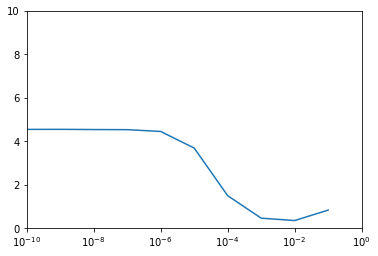

In [ ]:
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-10, 1, 0, 10])

Again, the model is trained beforehand and just expects new weights. Upload "alphaModel.h5" on prompt.

In [ ]:
alphaModel.compile(tf.keras.optimizers.Adam(lr=1e-8), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
files.upload()
alphaModel.load_weights("alphaModel.h5")
#alphaModel.fit(train_datagen.flow(train_X, train_y, batch_size=100), epochs=10, validation_data = test_datagen.flow(test_X, test_y, batch_size=100))

Saving alphaModel.h5 to alphaModel.h5


Saving weights

In [ ]:
#alphaModel.save_weights("alphaModel.h5")
#files.download("alphaModel.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

These are the functions that would classify any 28 X 28 image using the alphaModel (classifyAlpha to classify alphabets) and digiModel (classifyDigi to classify digits)

In [ ]:
def classifyDigi(img):
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  classes = digiModel.predict(x)
  return digiLabels[np.argmax(classes[0])]

def classifyAlpha(img):
  img = cv2.flip(img, 1)
  img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE) 
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  classes = alphaModel.predict(x)
  return alphaLabels[np.argmax(classes[0])]

Here we loop through all the contours, crop, process and store them in an array called blocks, this will be used for the final parsing.
Steps in processing: <br>
1) Cropping according to the bounding box from the contours. We weed out unnecessary contours by the if statament.<br>
2) Resize to 28X28<br>
3) Histogram equalization enhances the character. <br>
4) Basically the threshold function except it converts image to a 0/255 image.<br>
5) Store in blocks after converting it to 0/1 image. <br>

In [ ]:
blocks = []
i = 0
for c in page1Contours:
    x, y, w, h = cv2.boundingRect(c)
    if h < 40 and h>10 and w < 70 and w>20:
      img = cv2.cvtColor(result[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)
      img = 255 - cv2.resize(img, (28, 28), interpolation = cv2.INTER_CUBIC)
      img = cv2.equalizeHist(img)
      img[img>200] = 255
      img[img<=200] = 0
      cv2_imshow(img)
      print(i)
      i+=1
      blocks.append(img/255)

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


This is the least generalizable block of code in the whole project. This HAS to be manual for every new form that is being prepared for OCR. Basically hardcodes the found contours and matches them to their respective variables. A nice trick I used to process checkmarks was by using the basic observations that the checked boxes will always have a higher amount of 1's (after processing) as compared to the empty ones. 

In [ ]:
packageLiability = "Liability" if len(blocks[2][blocks[2] >0.5]) > len(blocks[3][blocks[3] >0.5]) else "Package"

proposal = ["New", "Renewal", "Roll Over", "Used", "Endorsement"]
temp = []
for i in range(11, 16):
  temp.append(len(blocks[i][blocks[i] >0.5]))
proposal = proposal[-np.argmax(temp)-1]

car2wheeler = "Pvt Car" if len(blocks[17][blocks[17] >0.5]) > len(blocks[16][blocks[16] >0.5]) else "Two Wheeler"

agreementCode = ""
for i in range(18,26): 
  agreementCode += classifyDigi(blocks[i])
agreementCode = agreementCode[::-1]

RMCode = ""
for i in range(26,33): 
  RMCode += classifyDigi(blocks[i])
RMCode = RMCode[::-1]

ProposalNo = ""
for i in range(33,53): 
  ProposalNo += classifyDigi(blocks[i])
ProposalNo = ProposalNo[::-1]

agreementName = ""
for i in range(53,61): 
  b = blocks[i][:, :26]*255
  b = cv2.resize(b, (28,28), interpolation = cv2.INTER_CUBIC)
  b[b>128] = 255
  b[b<=128] = 0
  agreementName += classifyAlpha(b/255)
agreementName = agreementName[::-1]

SRMCode = ""
for i in range(61,68): 
  SRMCode += classifyDigi(blocks[i])
SRMCode = SRMCode[::-1]

QuoteNo = ""
for i in range(68,88): 
  QuoteNo += classifyDigi(blocks[i])
QuoteNo = QuoteNo[::-1]

import datetime
date = ""
for i in range(88,96): 
  date += classifyDigi(blocks[i])
date = date[::-1]
date = datetime.datetime.strptime(date, '%d%m%Y')

ReceiptNo = ""
for i in range(96,103): 
  ReceiptNo += classifyDigi(blocks[i])
ReceiptNo = ReceiptNo[::-1]

InwardNo = ""
for i in range(103,123): 
  InwardNo += classifyDigi(blocks[i])
InwardNo = InwardNo[::-1]

SPCode = ""
for i in range(123,134): 
  SPCode += classifyDigi(blocks[i])
SPCode = SPCode[::-1]

BISNo = ""
for i in range(134,154): 
  BISNo += classifyDigi(blocks[i])
BISNo = BISNo[::-1]


CustomerSegment = ["Agency", "Banca", "Corporate/Broking", "Direct"]
temp = []
for i in range(154, 158):
  temp.append(len(blocks[i][blocks[i] >0.5]))
CustomerSegment = CustomerSegment[-np.argmax(temp)-1]

Sector = ["Urban", "Rural", "Social"]
temp = []
for i in range(158, 161):
  temp.append(len(blocks[i][blocks[i] >0.5]))
Sector = Sector[-np.argmax(temp)-1]

Final results. From here it can be put to a dataset, made into an API, the list is endless. Error can be minimized following methods enlisted in "extra.pdf". However, the digiModel is highly accurate and generalizes well among different handwritings.

In [ ]:
print("Package/Liability: " + packageLiability)
print("Pvt Car/ 2 wheeler: " + car2wheeler)
print("Proposal for: " + proposal)
print("Proposal Number: " + ProposalNo)
print("RM Code: " + RMCode)
print("Agreement Code: " + agreementCode)
print("Quote Number: " + QuoteNo)
print("Secondary RM Code: " + SRMCode)
print("Agreement Name: " + agreementName)
print("Inward Number: " + InwardNo)
print("Receipt Number: " + ReceiptNo)
print("Receipt Date: " + str(date))
print("Break-in Inspection Number: " + BISNo)
print("SP Code: " + SPCode)
print("Business Sector: " + Sector)
print("Customer Segment: " + CustomerSegment)

Package/Liability: Liability
Pvt Car/ 2 wheeler: Two Wheeler
Proposal for: Used
Proposal Number: 12345678901234567890
RM Code: 7156437
Agreement Code: 12345678
Quote Number: 34567899876543210123
Secondary RM Code: 2465218
Agreement Name: qcdeyqgq
Inward Number: 23484128943639246842
Receipt Number: 1246789
Receipt Date: 2000-12-12 00:00:00
Break-in Inspection Number: 14667072624764157931
SP Code: 12345678910
Business Sector: Urban
Customer Segment: Corporate/Broking
